# Scattering from a sphere using a combined direct formulation

### Background

In this tutorial we will solve the problem of scattering from the unit sphere $\Omega$ using a combined integral formulation and an incident wave:

$$
u^{\text{inc}}(\mathbf x) = e^{i k x},
$$

where $\mathbf x = (x, y, z)^t$.

The PDE is given by the Helmholtz equation:

$$
\Delta u + k^2 u = 0, \quad \text{ in } \mathbb{R}^3 \backslash \Omega,
$$

where $u=u_s+u_{inc}$ is the total acoustic field and $u_{s}$ satisfies the Sommerfeld radiation condition

$$
\frac{\partial u_s}{\partial r}-iku_s=o(r^{-1})
$$

for $r:=\frac{\mathbf x}{|x|}\rightarrow\infty$.

From Green's representation formula one can derive that

$$
u(\mathbf x) = u_{inc}-\int_{\Gamma}g(\mathbf x,\mathbf y)u_n(\mathbf y)ds(y).
$$

Here, $g(\mathbf x, \mathbf y)$ is the acoustic Green's function given as

$$
g(\mathbf x, \mathbf y):=\frac{e^{i k \|\mathbf{x}-\mathbf{y}\|}}{4 \pi \|\mathbf{x}-\mathbf{y}\|}.
$$

The problem has therefore been reduced to computing the normal derivative $u_n$ on the boundary $\Gamma$. This is achieved through the following boundary integral equation formulation.

$$
(\frac12I + D_k' - i \eta S_k) u_n = \frac{\partial u^{\text{inc}}}{\partial \nu}(x) - i \eta u^{\text{inc}}(x), \quad x \in \Gamma.
$$

where $I,D_k'$ and $S_k$ are respectively the identity operator, the adjoint double layer boundary operator and the single layer boundary operator. More details of the derivation of this formulation and its properties can be found in the article [*S. N. Chandler-Wilde, I. G. Graham, S. Langdon and E. A. Spence, Numerical-asymptotic boundary integral methods in high frequency acoustic scattering*](http://journals.cambridge.org/action/displayAbstract?fromPage=online&aid=8539370&fileId=S0962492912000037).


### Implementation

First we import the bempp module and numpy.

In [34]:
import bempp.api
import numpy as np

We define the wavenumber

In [35]:
k = 15.

The rhs of the combined formulation is defined as follows.

In [36]:
def combined_data(x, n, domain_index, result):
    result[0] = 1j * k * np.exp(1j * k * x[0]) * (n[0]-1) 

The following command creates a sphere mesh.

In [37]:
grid = bempp.api.shapes.regular_sphere(5)

As basis functions we use piecewise constant functions over the elements of the mesh. The corresponding space is initialized as follows.

In [38]:
piecewise_const_space = bempp.api.function_space(grid, "DP", 0)

We now initialize the boundary operators.
A boundary operator always takes at least three space arguments: a domain space, a range space and the test space (dual to the range). In this example we only work on the space $L^2(\Gamma)$ and we can choose all spaces to be identical.

In [39]:
identity = bempp.api.operators.boundary.sparse.identity(
    piecewise_const_space, piecewise_const_space, piecewise_const_space)
adlp = bempp.api.operators.boundary.helmholtz.adjoint_double_layer(
    piecewise_const_space, piecewise_const_space, piecewise_const_space,k)
slp = bempp.api.operators.boundary.helmholtz.single_layer(
    piecewise_const_space, piecewise_const_space, piecewise_const_space,k)

Standard arithmetic operators can be used to create linear combinations of boundary operators.

In [40]:
lhs = .5*identity + adlp - 1j * k * slp

We now discretize the right-hand side. Here, this means converting the Python callable `data_fun` into a GridFunction defined on the elements of the grid.

In [41]:
grid_fun = bempp.api.GridFunction(piecewise_const_space, fun=combined_data)

INFO:BEMPP:IDENTITY. START ASSEMBLY. Dim: (8192,8192). Assembly Type: sparse
INFO:BEMPP:IDENTITY. FINISHED ASSEMBLY. Time: 2.78E-02 sec.


We can now use GMRES to solve the problem.

In [42]:
from bempp.api.linalg import gmres
neumann_fun,info = gmres(lhs, grid_fun, tol=1E-5)

INFO:BEMPP:IDENTITY. START ASSEMBLY. Dim: (8192,8192). Assembly Type: sparse
INFO:BEMPP:IDENTITY. FINISHED ASSEMBLY. Time: 2.93E-02 sec.
INFO:BEMPP:ADJ_DLP. START ASSEMBLY. Dim: (8192,8192). Assembly Type: hmat
INFO:BEMPP:ADJ_DLP. FINISHED ASSEMBLY. Time: 9.85E+00 sec. Mem Size (Mb): 1.03E+02. Compression: 1.00E-01
INFO:BEMPP:SLP. START ASSEMBLY. Dim: (8192,8192). Assembly Type: hmat
INFO:BEMPP:SLP. FINISHED ASSEMBLY. Time: 9.04E+00 sec. Mem Size (Mb): 1.04E+02. Compression: 1.02E-01
INFO:BEMPP:IDENTITY. START ASSEMBLY. Dim: (8192,8192). Assembly Type: sparse
INFO:BEMPP:IDENTITY. FINISHED ASSEMBLY. Time: 4.01E-02 sec.


`gmres` returns a grid function `neumann_fun` and an integer `info`. When everything works fine info is equal to 0. 

At this stage, we have the surface solution of the integral equation. Now we will evaluate the solution in the domain of interest. We define the evaluation points as follows.

In [43]:
Nx = 200
Ny = 200
xmin, xmax, ymin, ymax = [-3, 3, -3, 3]
plot_grid = np.mgrid[xmin:xmax:Nx * 1j, ymin:ymax:Ny * 1j]
points = np.vstack((plot_grid[0].ravel(), plot_grid[1].ravel(), np.zeros(plot_grid[0].size)))
u_evaluated = np.zeros(points.shape[1], dtype=np.complex128)
u_evaluated[:] = np.nan

Then we create a single layer potential operator and use it to evaluate the solution at the evaluation points.

In [44]:
x, y, z =points
idx = np.sqrt(x**2 + y**2) > 1.0

The variable idx allows to compute only points located outside the unit circle of the plane. We use a single layer potential operator to evaluate the solution at the observation points.

In [45]:
from bempp.api.operators.potential import helmholtz as helmholtz_potential
slp_pot=helmholtz_potential.single_layer(piecewise_const_space,points[:,idx],k)
res = np.real(np.exp(1j *k * points[0,idx]) - slp_pot.evaluate(neumann_fun))
u_evaluated[idx] = res.flat

INFO:BEMPP:POTENTIAL OPERATOR ASSEMBLY START. Number of points: 36548. Space dimension: 8192. Assembly type: hmat 
INFO:BEMPP:FINISHED POTENTIAL OPERATOR ASSEMBLY. Time: 6.37E+00 sec.


We can now easily plot a slice of the domain solution.

/Users/betcke/python/python3.5/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


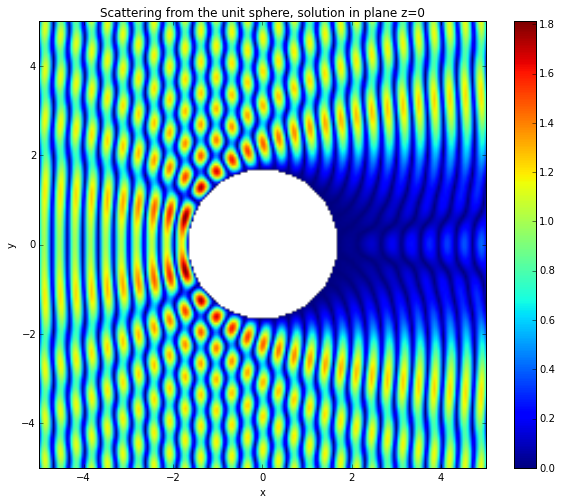

In [47]:
u_evaluated=u_evaluated.reshape((Nx, Ny))

%matplotlib inline 
# Plot the image
from matplotlib import pyplot as plt
fig = plt.figure(figsize =(10, 8))
plt.imshow(np.abs(u_evaluated.T),extent=[-5, 5, -5, 5])
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.title("Scattering from the unit sphere, solution in plane z=0")